In [93]:
from astropy.io import fits
import numpy as np 
from astropy.stats import sigma_clipped_stats
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from spectral_cube import SpectralCube as SC
from astropy import wcs
from astropy import units as u
import numpy.ma as ma
from pyBBarolo.wrapper import PVSlice
from astropy.table import Table
BBmain = "/Users/blanca/Documents/TESIS/software/Bbarolo/BBarolo" 
#from photutils import detect_sources
fname = "/Users/blanca/Documents/TESIS/software/datacubes/ngc2403.fits"

hdulist = fits.open(fname)
#hdulist[0].data


In [ ]:
def plot_channels(fname, skip=3, with_contours=True):
    image = fits.getdata(fname)  # numpy array, my data
    # row number is y coordinate so it is (rows, columns), (y,x) this is for a 2d one, but if i take a 3d? (z,y,x)

    num_slices = image.shape[0] // skip  # Only take 1/skip of the slices
    num_cols = 3
    num_rows = (num_slices + num_cols - 1) // num_cols  # Calculate the number of rows needed

    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 15))
    ax = ax.flatten()  # Flatten the array to make indexing easier
    for k in range(0, image.shape[0], skip):  # Skip channels based on the skip parameter
        mean, median, std = sigma_clipped_stats(image[k], sigma=2.0)
        if with_contours:
            cont_level_k = [std * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
            ax[k // skip].contour(image[k], levels=cont_level_k, cmap='viridis_r')
        ax[k // skip].imshow(image[k], cmap="Greys", origin="lower")

    # Hide any unused subplots
    for i in range((image.shape[0] + skip - 1) // skip, len(ax)):
        fig.delaxes(ax[i])

    plt.show()

In [40]:
def calculate_SNR(fname):
    image = fits.getdata(fname) 
    SNR = []
    k = 0
    while k < image.shape[0]:
        mean, median, std = sigma_clipped_stats(image[k], sigma=100)
        mx = ma.masked_array(image[k], mask=image[k] < mean + 5 * std)

        if mx.compressed().size == 0 or mx.data[mx.mask].size == 0:
            k += 1
            continue

        in_mask_mean = np.mean(mx.compressed())  # Data that i see
        out_mask_mean = np.std(mx.data[mx.mask])  # Data eliminated by mask

        if np.isnan(in_mask_mean) or np.isnan(out_mask_mean):
            if k > 1:
                SNR = SNR[:-2]  # Remove the last 2 values
            k += 2  # Skip the next 2 values
            continue

        SNR.append(in_mask_mean / out_mask_mean)
        k += 1

    total_SNR = np.mean(SNR)
    return SNR, total_SNR

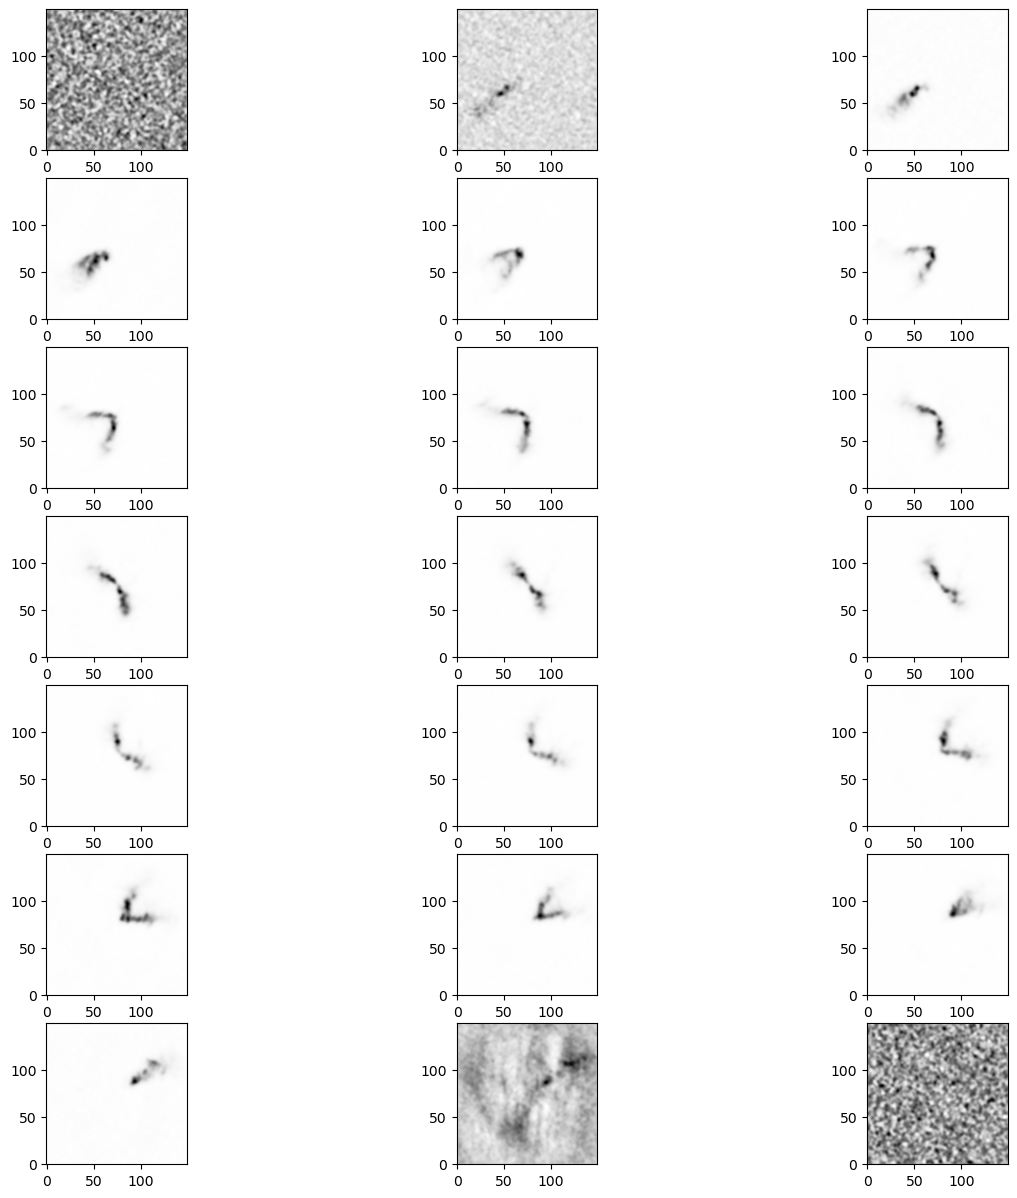

SNR:  13.391067
SNR per channel:  [5.4153905, 8.257877, 11.632411, 14.054893, 15.253328, 15.176241, 14.386279, 13.621599, 12.8276825, 12.305292, 12.973167, 14.419888, 15.4783325, 15.287449, 15.099981, 15.101519, 14.885072, 14.246581, 13.49319, 13.236018, 13.629368, 14.073684, 14.088936, 14.203511, 14.344981, 14.721781, 14.501268, 13.782194, 13.710611, 13.971306, 14.025053, 14.065634, 14.166455, 14.094522, 14.200747, 14.166962, 13.686158, 13.347007, 13.802971, 13.896126, 13.649566, 13.604946, 13.590378, 13.413427, 14.027936, 14.026061, 14.118781, 14.229385, 14.007239, 14.758955, 15.785762, 15.6097555, 14.503648, 11.21061, 8.086355, 5.4234424, 5.613053]


In [58]:
plot_channels(fname, skip=3, with_contours=False)

SNR, total_SNR = calculate_SNR(fname)
print("SNR: ", total_SNR)   
print("SNR per channel: ", SNR)

original shape of cube: (62, 150, 150)


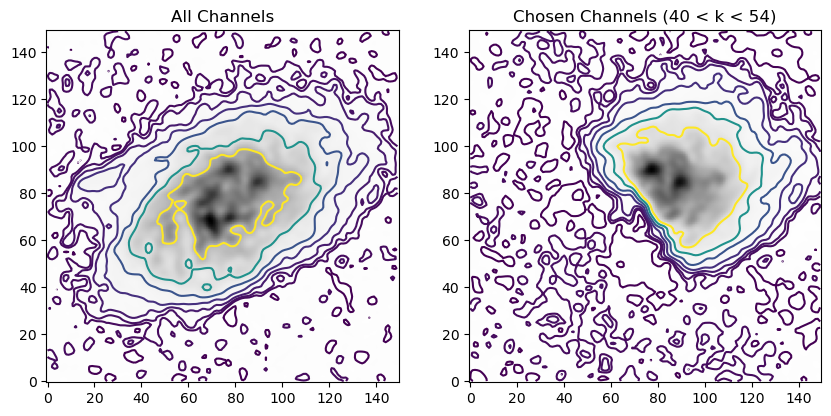

In [51]:
head = fits.getheader(fname)
image = fits.getdata(fname) #numpy array, my data
print("original shape of cube:" , image.shape)
# row number is y coordinate so it is (rows, columns), (y,x) this is for a 2d one, but if i take a 3d? (z,y,x)

all_channels = np.zeros((image.shape[1], image.shape[2]))
choose_channels = np.zeros((image.shape[1], image.shape[2]))

for k in range (image.shape[0]):
    all_channels = image[k]+all_channels
    if 30<k<54:
        choose_channels = image[k]+choose_channels

mean1, meadian1, std1 = sigma_clipped_stats(all_channels, sigma=2.0)
mean2, meadian2, std2 = sigma_clipped_stats(choose_channels, sigma=2.0)

plt.rcParams['figure.figsize'] = [10, 5]

fig, axs = plt.subplots(1, 2)

cont_level_all = [std1 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
cax0 = axs[0].contour(all_channels, levels=cont_level_all, cmap='viridis')
axs[0].imshow(all_channels, cmap="Greys", origin="lower")
axs[0].set_title('All Channels')

cont_level_choose = [std2 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
cax1 = axs[1].contour(choose_channels, levels=cont_level_choose, cmap='viridis')
axs[1].imshow(choose_channels, cmap="Greys", origin="lower")
axs[1].set_title('Chosen Channels (40 < k < 54)')


plt.show()

#def choose_zmin_zmax(fname):
    

In [144]:
def plot_PV(fname1, fname2, ringfile1, ringfile2, output):
    c = Table.read(ringfile1, format='ascii')
    cube_maj = PVSlice(fitsname=fname1, XPOS_PV=np.mean(c['XPOS']), YPOS_PV=np.mean(c['YPOS']), PA_PV=np.mean(c['PA']), OUTFOLDER=output)
    cube_maj.run(BBmain)
    
    cube_min = PVSlice(fitsname=fname1, XPOS_PV=np.mean(c['XPOS']), YPOS_PV=np.mean(c['YPOS']), PA_PV=np.mean(c['PA'] + 90), OUTFOLDER=output)
    cube_min.run(BBmain)
    c_head = fits.open(fname1)
    name1 = c_head[0].header["OBJECT"]

    m = Table.read(ringfile2, format='ascii')
    model_maj = PVSlice(fitsname=fname2, XPOS_PV=np.mean(m['XPOS']), YPOS_PV=np.mean(m['YPOS']), PA_PV=np.mean(m['PA']), OUTFOLDER=output)
    model_maj.run(BBmain)

    model_min = PVSlice(fitsname=fname2, XPOS_PV=np.mean(m['XPOS']), YPOS_PV=np.mean(m['YPOS']), PA_PV=np.mean(m['PA'] + 90), OUTFOLDER=output)
    model_min.run(BBmain)
    m_head = fits.open(fname2)
    name2 = m_head[0].header["OBJECT"]

    im_cube_maj = fits.getdata(f'{output}{name1}pv_{int(np.mean(c['PA']))}.fits')
    im_cube_min = fits.getdata(f'{output}{name1}pv_{int(np.mean(c['PA'])+90)}.fits')
    im_model_maj = fits.getdata(f'{output}{name2}pv_{int(np.mean(c['PA']))}.fits')
    im_model_min = fits.getdata(f'{output}{name2}pv_{int(np.mean(c['PA'])+90)}.fits')

    fig, axs = plt.subplots(1, 2, figsize=(15, 12))
    mean1, meadian1, std1 = sigma_clipped_stats(im_cube_maj, sigma=5)
    cont_level_1 = [std1 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
    im1 = axs[0].imshow(im_cube_maj, cmap="Reds", origin="lower")
    axs[0].contour(im_cube_maj, levels=cont_level_1, cmap='Reds_r', linewidths=1)
    fig.colorbar(im1, ax=axs[0])

    mean2, meadian2, std2 = sigma_clipped_stats(im_model_maj, sigma=5)
    cont_level_2 = [std2 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
    axs[0].contour(im_model_maj, levels=cont_level_2, cmap='Blues_r', linewidths=1)
    axs[0].imshow(im_model_maj, cmap="Blues", origin="lower", alpha=0.5)
    axs[0].set_title("Slice at angle " + str(int(np.mean(c['PA']))) + "°")
    axs[0].set_xlabel('Offset(arcsec)')
    axs[0].set_ylabel('LOS velocity (km/s)')

    mean3, meadian3, std3 = sigma_clipped_stats(im_cube_min, sigma=5)
    cont_level_3 = [std3 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
    im2 = axs[1].imshow(im_cube_min, cmap='Reds', origin='lower')
    axs[1].contour(im_cube_min, levels=cont_level_3, cmap='Reds_r', linewidths=1)
    fig.colorbar(im2, ax=axs[1])

    mean4, meadian4, std4 = sigma_clipped_stats(im_model_min, sigma=5)   
    cont_level_4 = [std4 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
    axs[1].contour(im_model_min, levels=cont_level_4, cmap='Blues_r', linewidths=1)
    axs[1].imshow(im_model_min, cmap='Blues', origin='lower', alpha=0.5)
    axs[1].set_title("Slice at angle " + str(int(np.mean(c['PA']))+90) + "°")
    axs[1].set_xlabel('Offset(arcsec)')
    axs[1].set_ylabel('LOS velocity (km/s)')

    plt.savefig(f'{output}PV_plot.png')
    plt.show()



=====                                                           =====
=====                Welcome to BBarolo v1.7.8dev               =====
=====                                                           =====


-------------------------- Parameters -------------------------

FITS file to be analysed..........................[FITSFILE]  =  /Users/blanca/Documents/TESIS/software/THESIS/models/model1/model1.fits
Number of threads..................................[THREADS]  =  8
Producing output plots?..............................[PLOTS]  =  true
Showing progress bars?.............................[SHOWBAR]  =  true
Printing output messages?..........................[VERBOSE]  =  true
Directory where outputs are written..............[OUTFOLDER]  =  /Users/blanca/Documents/TESIS/software/THESIS/pv_plot/test/
Redirect output messages to a file?................[LOGFILE]  =  false
Using robust statistics?...................[flagRobustStats]  =  true
Whether to convert flux to Jy?............

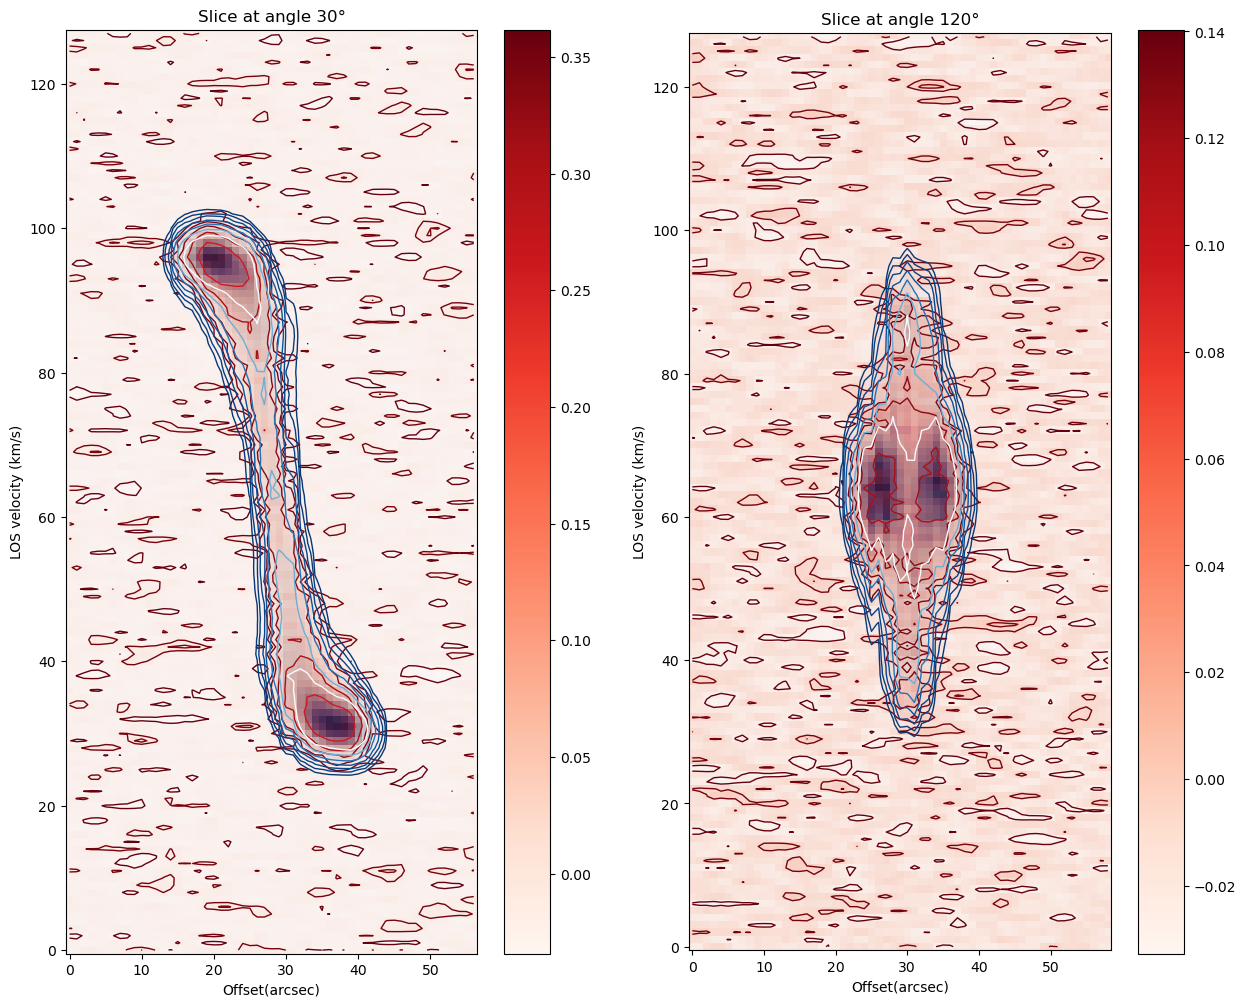

In [146]:
cube = "/Users/blanca/Documents/TESIS/software/THESIS/models/model1/model1.fits"
ring_cube = "/Users/blanca/Documents/TESIS/software/THESIS/models/model1/model1_params.txt"
model = "/Users/blanca/Documents/TESIS/software/THESIS/TESTS/tests_model1/model1_enrico/barbamodel/barbamodel.fits"
ring_model = "/Users/blanca/Documents/TESIS/software/THESIS/TESTS/tests_model1/model1_enrico/barbamodel/barbamodel_params.txt"

plot_PV(cube,model, ring_cube, ring_model,"/Users/blanca/Documents/TESIS/software/THESIS/pv_plot/test/")

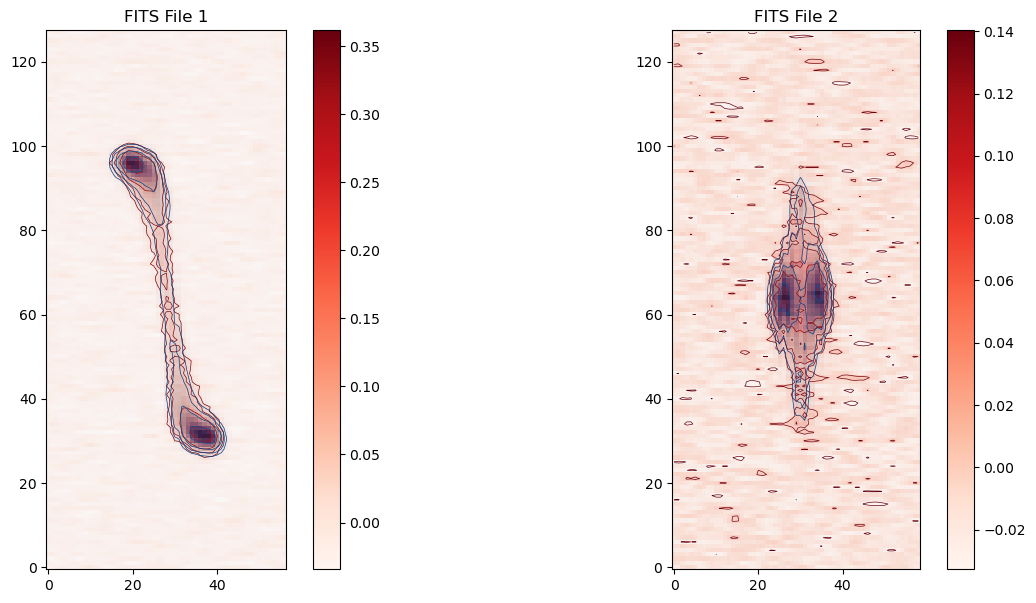

In [109]:
cubemaj = "/Users/blanca/Documents/TESIS/software/THESIS/models/model1/model1pv_30.fits"
cubemin = "/Users/blanca/Documents/TESIS/software/THESIS/models/model1/model1pv_120.fits"
modelmaj ="/Users/blanca/Documents/TESIS/software/THESIS/TESTS/tests_model1/model1_enrico/slices/barbamodelpv_30.fits"
modelmin ="/Users/blanca/Documents/TESIS/software/THESIS/TESTS/tests_model1/model1_enrico/slices/barbamodelpv_120.fits"

cubemaj = fits.getdata(cubemaj)
cubemin = fits.getdata(cubemin)
modelmaj = fits.getdata(modelmaj)
modelmin = fits.getdata(modelmin)

fig, axs = plt.subplots(1, 2, figsize=(15, 7))

mean1, meadian1, std1 = sigma_clipped_stats(cubemaj, sigma=100)
cont_level_1 = [std1 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
im1 = axs[0].imshow(cubemaj, cmap="Reds", origin="lower")
axs[0].contour(cubemaj, levels=cont_level_1, cmap='Reds_r', linewidths=0.5)

mean2, meadian2, std2 = sigma_clipped_stats(modelmaj, sigma=100)
cont_level_2 = [std2 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
axs[0].contour(modelmaj, levels=cont_level_2, cmap='Blues_r', linewidths=0.5)
axs[0].imshow(modelmaj, cmap="Blues", origin="lower", alpha=0.5)
axs[0].set_title('FITS File 1')
fig.colorbar(im1, ax=axs[0])

mean3, meadian3, std3 = sigma_clipped_stats(cubemin, sigma=100)
cont_level_3 = [std3 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
im2 = axs[1].imshow(cubemin, cmap='Reds', origin='lower')
axs[1].contour(cubemin, levels=cont_level_3, cmap='Reds_r', linewidths=0.5)

mean4, meadian4, std4 = sigma_clipped_stats(modelmin, sigma=100)   
cont_level_4 = [std4 * x for x in [-1, 1, 2, 4, 8, 16, 32, 64]]
axs[1].contour(modelmin, levels=cont_level_4, cmap='Blues_r', linewidths=0.5)
axs[1].imshow(modelmin, cmap='Blues', origin='lower', alpha=0.5)
axs[1].set_title('FITS File 2')
fig.colorbar(im2, ax=axs[1])

plt.show()

In [108]:
cubemaj = "/Users/blanca/Documents/TESIS/software/THESIS/models/model1/model1pv_30.fits"
cubemin = "/Users/blanca/Documents/TESIS/software/THESIS/models/model1/model1pv_120.fits"
modelmaj ="/Users/blanca/Documents/TESIS/software/THESIS/TESTS/tests_model1/model1_enrico/slices/barbamodelpv_30.fits"
modelmin ="/Users/blanca/Documents/TESIS/software/THESIS/TESTS/tests_model1/model1_enrico/slices/barbamodelpv_120.fits"